In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plasma_tv.data.file_utils import GetEmission, GetPkl
from plasma_tv.utils.helpers import noisify

In [2]:
tv = GetEmission('../data/raw/all')
files = tv.list_files(False)
all_file_idx = 20
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid_train] = tv.load_all(files[all_file_idx])
tv_pkl = GetPkl('../data/raw/aza_debug')
files_pkl = tv_pkl.list_files(False)
total_vid = []
# for file in files_pkl[35:]:
#     [vid,vid_times] = tv_pkl.load_processed(file)
#     total_vid.append(vid)
# total_vid = np.vstack(total_vid)
file_idx = 68
vid, vid_times = tv_pkl.load_raw(files_pkl[file_idx])

Number of files: 26
Extracting sav for shot: 199171


Resizing...
Number of files: 78


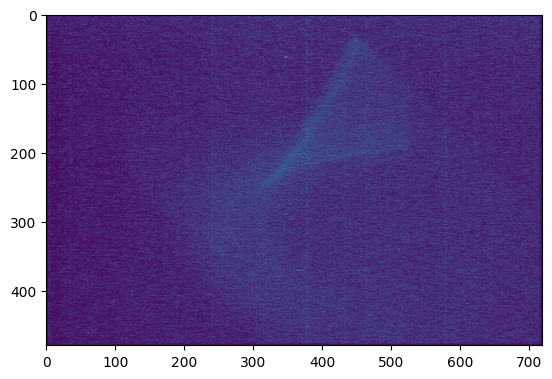

In [3]:
plt.imshow(vid[45])

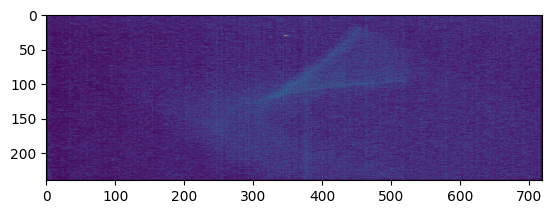

In [4]:
vid, vid_times = tv_pkl.load_processed(files_pkl[file_idx])
plt.imshow(vid[45])

In [5]:
def compute_histograms(image_array, num_bins=256):
    N = image_array.shape[0]
    histograms = []
    for i in range(N):
        image = image_array[i]
        hist, bin_edges = np.histogram(image.ravel(), bins=num_bins, range=(0, 1), density=False)
        histograms.append(hist)
    return histograms, bin_edges

def compute_average_histogram(histograms):
    sum_hist = np.sum(histograms, axis=0)
    avg_hist = sum_hist / np.sum(sum_hist)
    return avg_hist

# Step 2: Compute the CDF of the average histogram
def compute_cdf(hist):
    cdf = np.cumsum(hist)
    cdf_normalized = cdf / cdf[-1]
    return cdf_normalized

# Step 3: Match images to the average histogram
def match_image_to_histogram(image, target_cdf, bin_edges):
    src_hist, _ = np.histogram(image.ravel(), bins=bin_edges, density=False)
    src_cdf = np.cumsum(src_hist)
    src_cdf_normalized = src_cdf / src_cdf[-1]
    interp_values = np.interp(src_cdf_normalized, target_cdf, bin_edges[:-1])
    matched_image = np.interp(image.ravel(), bin_edges[:-1], interp_values)
    return matched_image.reshape(image.shape)

def match_images_to_histogram(image_array, target_cdf, bin_edges):
    M = image_array.shape[0]
    matched_images = np.empty_like(image_array)
    for i in range(M):
        matched_images[i] = match_image_to_histogram(image_array[i], target_cdf, bin_edges)
    return matched_images * 255

images_N = vid.astype(np.float32)[45:-90] / 255.0

In [6]:
vid_noisy = noisify(vid_train)
images_M = vid_noisy.astype(np.float32) / 255.0

# # Compute the average histogram
# histograms, bin_edges = compute_histograms(images_N)
# avg_hist = compute_average_histogram(histograms)
# target_cdf = compute_cdf(avg_hist)

# # save target_cdf, bin_edges to numpy
# np.save('target_cdf.npy', target_cdf)
# np.save('bin_edges.npy', bin_edges)

In [8]:
print(images_N.shape[1] * images_N.shape[2])

172800


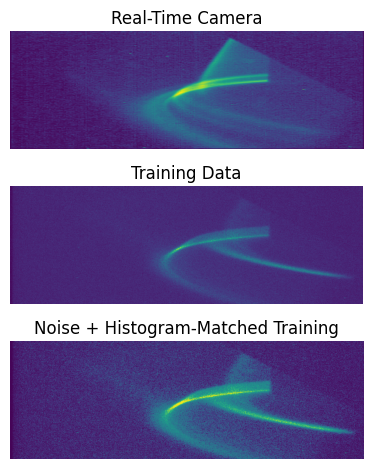

In [7]:
# load target_cdf, bin_edges from numpy
target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')
matched_images = match_images_to_histogram(images_M, target_cdf, bin_edges)
plt.subplot(3,1,1)
plt.imshow(images_N[90])
plt.title('Real-Time Camera')
plt.axis('off')
plt.subplot(3,1,2)
plt.imshow(images_M[90])
plt.title('Training Data')
plt.axis('off')
plt.subplot(3,1,3)
plt.imshow(matched_images[90])
plt.title('Noise + Histogram-Matched Training')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
index_dict = {
            "inverted": 0,
            "radii": 1,
            "elevation": 2,
            "frames": 3,
            "times": 4,
            "vid_frames": 5,
            "vid_times": 6,
            "vid": 7,
        }
dat_path = '/scratch/gpfs/nc1514/plasma-tv/data/raw/tv_images/filippo_dat/cam240perp_200978_f207_t3366.6247_1.dat'
data_dat = readsav(dat_path)
keys = ['inversion', 'camimage', 'virtimage', 'camera', 'shot', 'time', 'img_r', 'img_z']
inve_, cam_, virt_, cam, shot, time, img_r, img_z = [data_dat[key] for key in keys]

In [ ]:
from skimage.transform import resize

# Resize the image to 240 x 720
cam_resized = resize(virt_, (240, 720), anti_aliasing=True)
cam_rotate = np.flip(np.rot90(np.rot90(cam_resized)), axis=1)

with open('/scratch/gpfs/nc1514/plasma-tv/models/092324_tangtv_v2.txt', "r") as file:
    coef = file.readlines()
z_coef_ = np.array([float(i) for i in coef])
inter_ = -1.1381
cam_flatten = cam_rotate.reshape(-1)
pred_point = np.dot(z_coef_, cam_flatten) + inter_
print(pred_point)
# Display the resized image
plt.imshow(cam_rotate)
plt.title('Resized Image (240 x 720)')
plt.axis('off')
plt.show()
edit_img = vid[90].copy()
# edit_image = noisy('speckle', edit_img)
# edit_image = exposure.match_histograms(edit_image, frames_vid_aza[90])

cdf_aza = np.cumsum(frames_vid_aza[90].ravel())
cdf_edit = np.cumsum(edit_image.ravel())

plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.imshow(vid[90])
plt.axis('off')
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(frames_vid_aza[90])
plt.axis('off')
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(edit_image)
plt.axis('off')
plt.colorbar()
plt.show()

aza_hist = exposure.histogram(frames_vid_aza[140])
edit_hist = exposure.histogram(edit_image)
vid_hist = exposure.histogram(vid[50])

plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.plot(aza_hist[1], aza_hist[0])
plt.subplot(3,1,2)
plt.plot(edit_hist[1], edit_hist[0])
plt.subplot(3,1,3)
plt.plot(vid_hist[1], vid_hist[0])
plt.show()